In [6]:
import kagglehub

# Download latest version
IMAGE_PATH = kagglehub.dataset_download("arnaud58/landscape-pictures")

print("Path to dataset files:", path)

Path to dataset files: /Users/gabrielmindlberger/.cache/kagglehub/datasets/arnaud58/landscape-pictures/versions/2


In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

# 2. Device config
device = torch.device(
    'mps' if torch.backends.mps.is_available()
    else 'cuda' if torch.cuda.is_available()
    else 'cpu'
)
print(f'Using device: {device}')

Using device: mps


In [19]:
# 3. Hyperparameters
img_height, img_width = 256, 256
batch_size            = 16
num_epochs            = 1
learning_rate         = 1e-3

In [22]:
# 4. Dataset: load color image, generate grayscale on‐the‐fly
class ColorizationDataset(Dataset):
    def __init__(self, img_dir, transform_gray=None, transform_color=None):
        self.paths = sorted([
            os.path.join(img_dir, f)
            for f in os.listdir(img_dir)
            if f.lower().endswith(('.jpg','.png'))
        ])
        self.transform_gray  = transform_gray
        self.transform_color = transform_color

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        # color target
        target = img.copy()
        if self.transform_color:
            target = self.transform_color(target)
        # grayscale input
        gray = img.convert('L')
        if self.transform_gray:
            gray = self.transform_gray(gray)
        return gray, target

# 5. Transforms (resize + ToTensor)
transform_gray = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])
transform_color = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
])

# 6. DataLoader
dataset   = ColorizationDataset(IMAGE_PATH, transform_gray, transform_color)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
print(f'Loaded {len(dataset)} images.')

Loaded 4319 images.


In [23]:
# 7. Model
class ImageColorizer(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = nn.Conv2d(1, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2,2)
        self.enc2 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2,2)
        self.enc3 = nn.Conv2d(128, 256, 3, padding=1)
        # Decoder
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec1 = nn.Conv2d(256, 128, 3, padding=1)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec2 = nn.Conv2d(128, 64, 3, padding=1)
        self.final = nn.Conv2d(64, 3, 3, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.enc1(x))
        x = self.pool1(x)
        x = self.relu(self.enc2(x))
        x = self.pool2(x)
        x = self.relu(self.enc3(x))
        x = self.up1(x)
        x = self.relu(self.dec1(x))
        x = self.up2(x)
        x = self.relu(self.dec2(x))
        x = self.sigmoid(self.final(x))
        return x

model     = ImageColorizer().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

ImageColorizer(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up1): Upsample(scale_factor=2.0, mode='nearest')
  (dec1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up2): Upsample(scale_factor=2.0, mode='nearest')
  (dec2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (final): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


Epoch 1/1: 100%|██████████| 270/270 [03:45<00:00,  1.20batch/s]


Epoch 1/1 — Loss: 0.0151


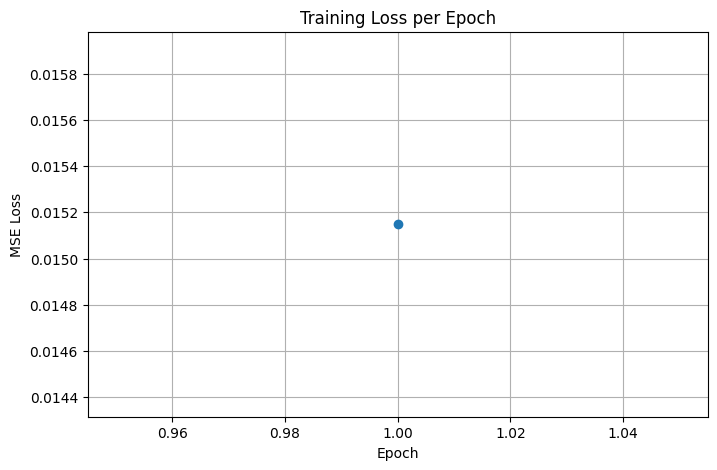

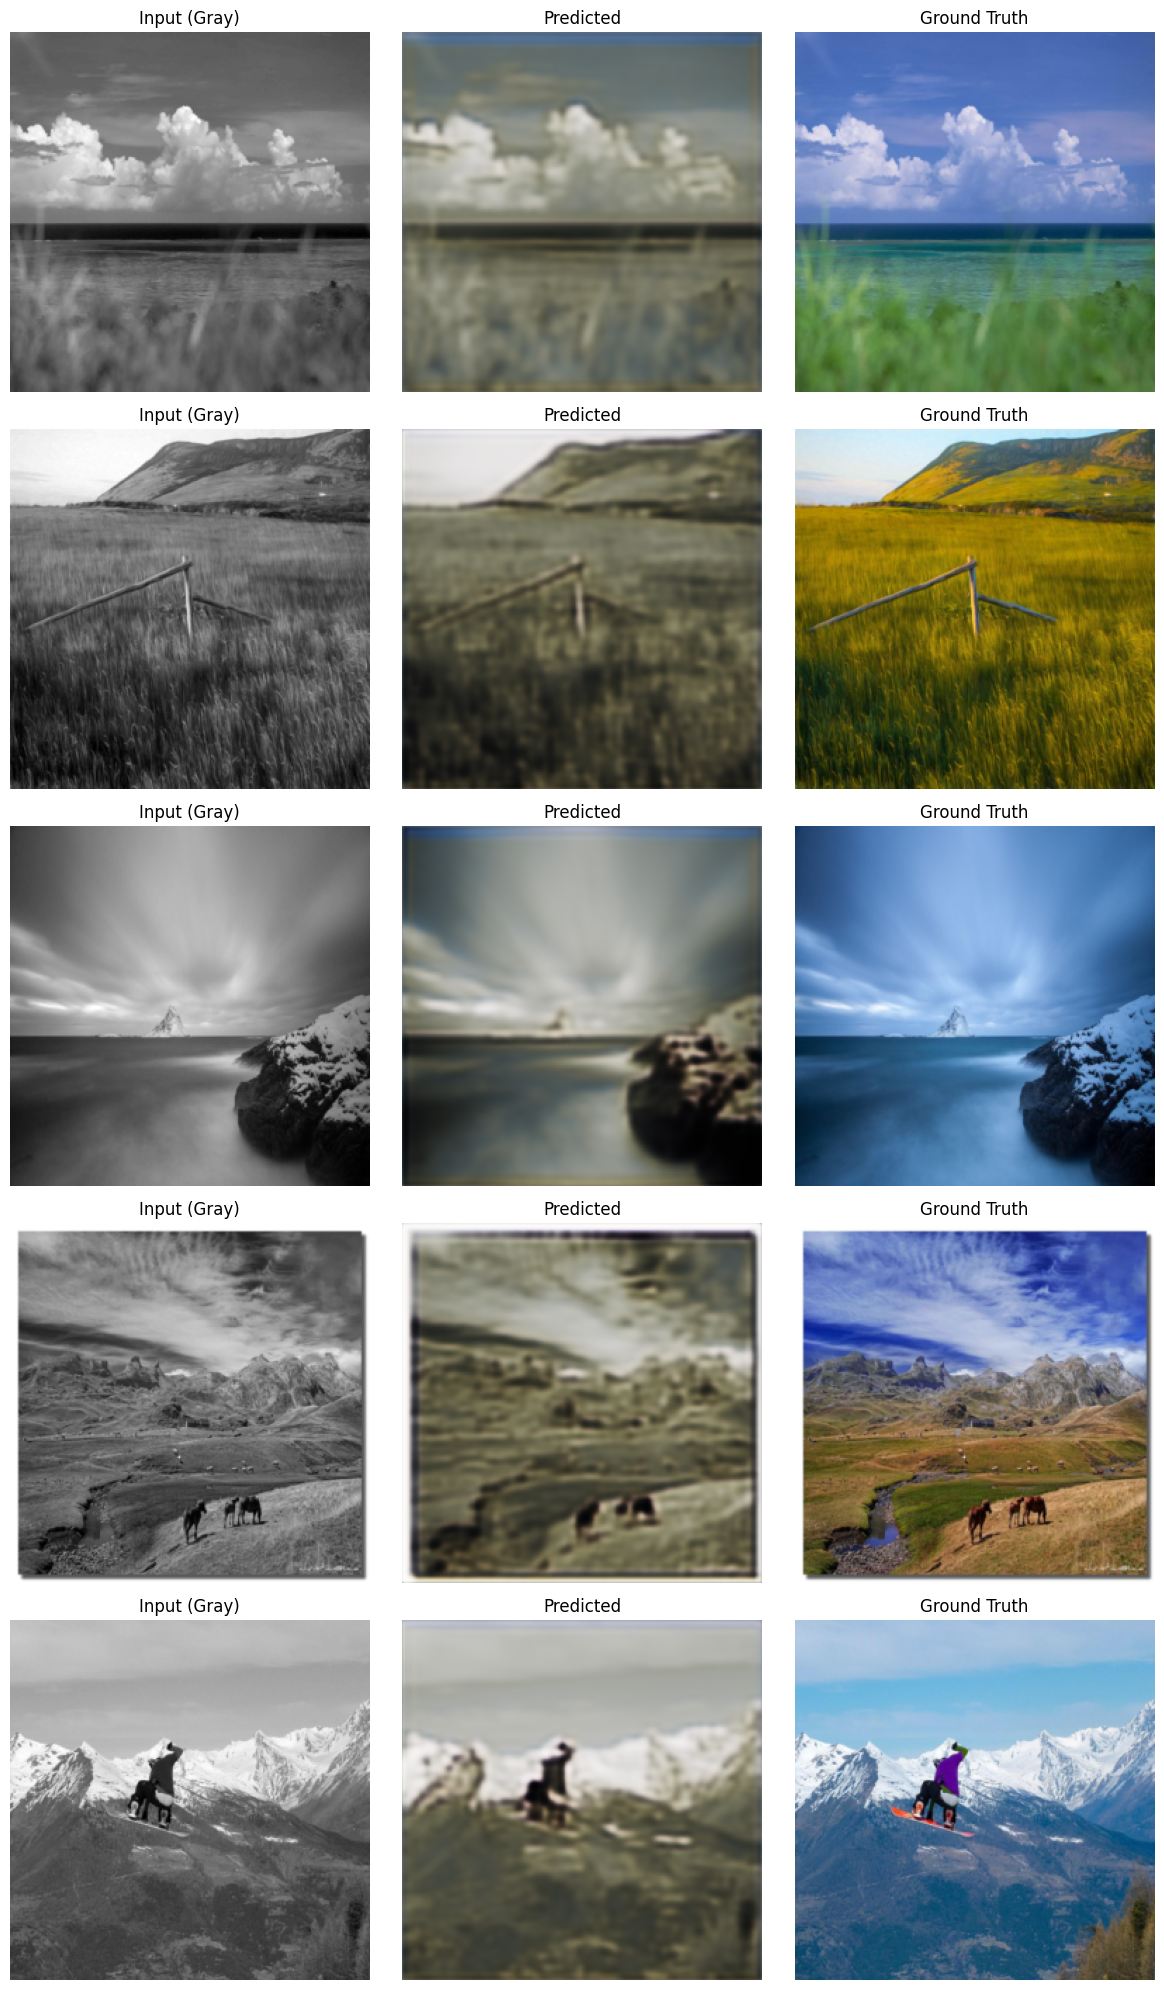

In [24]:
# 8. Training loop mit Loss-Tracking
loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for gray, color in tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
        gray  = gray.to(device)
        color = color.to(device)
        # forward
        outputs = model(gray)
        loss    = criterion(outputs, color)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * gray.size(0)
    epoch_loss = running_loss / len(dataset)
    loss_history.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs} — Loss: {epoch_loss:.4f}')

# 9. Trainingskurve plotten
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), loss_history, marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

# 10. Ergebnisse anzeigen
model.eval()
with torch.no_grad():
    gray_batch, true_color_batch = next(iter(dataloader))
    gray_batch  = gray_batch.to(device)
    pred_batch  = model(gray_batch).cpu()

n_display = min(5, gray_batch.size(0))
fig, axes = plt.subplots(n_display, 3, figsize=(12, 4 * n_display))
for i in range(n_display):
    axes[i,0].imshow(gray_batch[i].cpu().squeeze(), cmap='gray')
    axes[i,0].set_title('Input (Gray)')
    axes[i,0].axis('off')

    axes[i,1].imshow(pred_batch[i].permute(1,2,0))
    axes[i,1].set_title('Predicted')
    axes[i,1].axis('off')

    axes[i,2].imshow(true_color_batch[i].permute(1,2,0))
    axes[i,2].set_title('Ground Truth')
    axes[i,2].axis('off')

plt.tight_layout()
plt.show()